In [20]:
import os
import torch.nn as nn
from torch import optim
import tensorflow as tf
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch
from torchvision import datasets
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score,f1_score
import csv

In [21]:
# image normalization
def normalize_images(imgs):
    return imgs/255.

In [22]:
class Dataset:
    def __init__(self,train_or_test):
        data=datasets.FashionMNIST(root='fashion_mnist', download=True,train=train_or_test)
        self.x,self.y=data.data,np.array(data.targets)
        self.x=normalize_images(self.x)
        # self.y=onehot_encoding(self.y)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, item):
        return self.x[item],self.y[item]

In [23]:
# Create a PYTORCH dataset with one-hot encoding + normalization
# (Dataset's labels are already provedided in the appropriate form.)

In [24]:
# loading dataset
train=Dataset(train_or_test=True)
test=Dataset(train_or_test=False)
# answers
test.x[0].size()

torch.Size([28, 28])

In [29]:
# take a view on our dataset
def show_dataset(dataset_,dataset_labels_):
    # to show labels in convenient format
    figure = plt.figure(figsize=(6, 6))
    fashion_labels={0:"T-shirt/top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        # to pick random images
        sample_idx = tf.random.uniform(shape=(1,), minval=0, maxval=len(dataset_), dtype=tf.int64).numpy()[0]
        # retrieve image name and it's labels
        img, label = dataset_[sample_idx],fashion_labels[dataset_labels_[sample_idx]]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

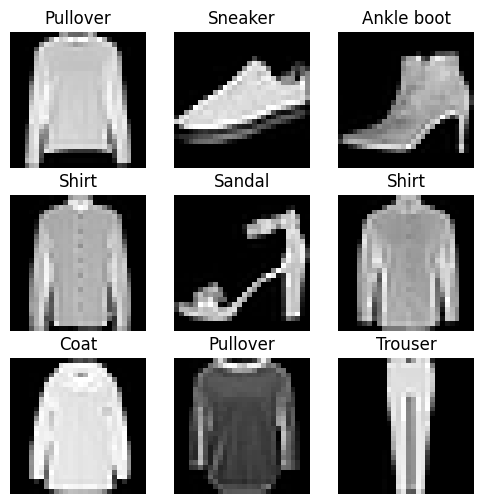

In [30]:
# take a view on dataset
show_dataset(train.x,train.y)

In [8]:
# batch_size=64
train_loader,test_loader=DataLoader(train,shuffle=True),DataLoader(test,shuffle=True)

In [9]:
loss_type=nn.CrossEntropyLoss()

In [10]:
# We have confusion matrix, where it is easy to identify true_positives, false_positives, true negatives.
# True Positives_A: The number of samples correctly classified as class A.
# False Positives_A: The number of samples that are not of class A but are incorrectly classified as class A.(numbers in rows)
# False Negatives_A: The number of samples of class A that are incorrectly classified as not being of class A.(numbers in columns)
# 
# True_positives              False_positives
# 
# False negatives             True negatives

In [11]:
def compute_precision_recall(matrix_):
    y_true,y_pred=[i[0] for i in matrix_],[i[1] for i in matrix_]
    # average = 'macro' => mеtrics are calculated across all classes for entire classification task
    precision=precision_score(y_true=y_true,y_pred=y_pred,average='macro')
    recall=recall_score(y_true=y_true,y_pred=y_pred,average='macro')
    f1_score_=f1_score(y_true=y_true,y_pred=y_pred,average='macro')
    return precision,recall,f1_score_

In [12]:
# drawing Confusion matrix for statistical analysis
def final_matrix(matrix,leng):
    my_matrix=torch.zeros(leng,leng,dtype=torch.int32).tolist()
    # fill the confusion matrix with values
    for i in matrix:
        my_matrix[i[0]][i[1]]+=1
    my_matrix=np.array(my_matrix)
    my_matrix=(my_matrix.T/my_matrix.sum(axis=1)).T
    my_matrix=np.round(my_matrix, 3)
    plt.figure(figsize=(30,36))
    # display matrix in blue colors
    disp = ConfusionMatrixDisplay(confusion_matrix=my_matrix, display_labels=range(10))
    disp.plot(cmap='Blues')
    # save to a folder
    plt.show()

In [13]:
def draw_plots(train_accuracy, test_accuracy, train_loss_, test_loss_):
    # To draw plots of accuracy and loss of train and test datasets
    plt.figure(figsize=(10, 7))
    plt.plot(train_accuracy, color='blue', linestyle='--',
             label='train accuracy')
    plt.plot(test_accuracy, color='red', linestyle='--',
             label='test accuracy')
    plt.ylabel = 'Accuracy'
    plt.xlabel = 'Epochs' 
    plt.legend()
    plt.show() 
    # Loss plot
    plt.figure(figsize=(10, 7))
    plt.plot(np.array(train_loss_), color='blue', linestyle='--',
             label='train loss')
    plt.plot(np.array(test_loss_), color='red', linestyle='--',
             label='test loss')
    plt.ylabel = 'Loss'     
    plt.xlabel = 'Epochs'   
    plt.legend()
    plt.show()  

In [14]:
from tqdm import tqdm

def training_process(loader, my_model, optimizer, loss):
    # Turn on the training mode
    my_model.train()
    running_correct, epoch_loss = 0, 0

    for i, (images, labels) in tqdm(enumerate(loader), total=len(loader)):
        # Gradients are reset to zero
        optimizer.zero_grad()
        outputs = my_model(images)
        _, predictions = torch.max(outputs.data, 1)
        loss_val = loss(outputs, labels)
        # Backward pass
        loss_val.backward()
        optimizer.step()

        # Accumulate statistics over the entire epoch
        epoch_loss += loss_val.item()
        running_correct += (labels == predictions).sum().item()

    # Calculate accuracy and average loss for the entire epoch
    accuracy = 100. * (running_correct / len(loader.dataset))
    epoch_loss /= len(loader)

    return epoch_loss, accuracy

In [15]:
def evaluating_perfomance(loader_test,my_model,loss,last_epoch=False):
        with torch.no_grad():
            # variables to draw confusion matrix
            Confusion_list=[]
            running_correct,epoch_loss=0,0
            total=0
        # no updating loss
            for images,labels in loader_test:
                # flatten image to use it in the model
                outputs=my_model(images)        
                # compute loss on test dataset
                loss_val=loss(outputs,labels)
                # compute the loss and divide by the size of test dataset (10000)
                epoch_loss=loss_val/len(loader_test)
                for index,i in enumerate(outputs):
                    # torch.argmax(i) -> from the array of predictions extract the biggest one 
                    if torch.argmax(i)==labels[index]:
                        running_correct+=1
                    total+=1
                _,predicted_labels=torch.max(outputs.data,1)
                # after last epoch prepare data for Confusion matrix and graphs
                if last_epoch:
                    predicted_data=list(zip(labels.tolist(),predicted_labels.tolist()))
                    Confusion_list.extend(predicted_data)
            # if it is the last epoch --> return the list for confusion matrix
            if not last_epoch:
                return epoch_loss,100.*round(running_correct/total,6),[]
            else:
                return epoch_loss,100.*round(running_correct/total,6),Confusion_list

In [34]:
def run_epochs(learning_rate=0.001,epochs=7,model_type=None):
    optimizer=optim.SGD(model_type.parameters(),lr=learning_rate)
    criterion=nn.CrossEntropyLoss()
    train_loss,testing_loss=[],[]
    train_acc,testing_acc=[],[]
    last_epoch=False
    confusion__matrix=[]
    for epoch in range(1,epochs+1):
            if epoch==epochs:
                last_epoch=True
            print(f"Epoch number: {epoch}")
            print()
            print('Training..')
            loss_,accuracy=training_process(loader=train_loader,my_model=model_type,loss=criterion,optimizer=optimizer)
            train_loss.append(loss_)
            train_acc.append(accuracy)
            print(f'Training_Loss: {loss_} and Training_Accuracy: {accuracy} %')
            print('Testing..')
            loss_test,accuracy_test,confusion__matrix=evaluating_perfomance(loader_test=test_loader,my_model=model_type,loss=criterion,last_epoch=last_epoch)
            testing_loss.append(loss_test)
            testing_acc.append(accuracy_test)
            print(f'Testing_Loss: {loss_test} and Testing_Accuracy: {accuracy_test} %')
            print()
            print('-'*80)
            print()
    final_matrix(matrix=confusion__matrix,leng=10)
    train_loss,testing_loss=[float(i) for i in train_loss],[float(i) for i in testing_loss]
    draw_plots(train_accuracy=train_acc,train_loss_=np.array(train_loss),test_loss_=np.array(testing_loss),test_accuracy=testing_acc)
    # call function to compute precision and recall, f1 score
    precision,recall,f1_score_=compute_precision_recall(confusion__matrix)
    return {'precision':precision,'recall':recall,'f1_score':f1_score_,'accuracy':testing_acc[-1],'min_loss':min(testing_loss)}

In [17]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x

In [18]:
model=Model()
model

Model(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

Epoch number: 1

Training..


100%|██████████| 60000/60000 [00:16<00:00, 3575.45it/s]


Training_Loss: 0.27326456471123883 and Training_Accuracy: 89.97166666666668 %
Testing..
Testing_Loss: 4.2601997847668827e-05 and Testing_Accuracy: 86.91 %

--------------------------------------------------------------------------------

Epoch number: 2

Training..


100%|██████████| 60000/60000 [00:16<00:00, 3562.59it/s]


Training_Loss: 0.2677431894840852 and Training_Accuracy: 89.99166666666667 %
Testing..
Testing_Loss: 3.131192897853907e-06 and Testing_Accuracy: 87.64 %

--------------------------------------------------------------------------------

Epoch number: 3

Training..


100%|██████████| 60000/60000 [00:16<00:00, 3559.80it/s]


Training_Loss: 0.26066862761306786 and Training_Accuracy: 90.36 %
Testing..
Testing_Loss: 9.417489010843383e-10 and Testing_Accuracy: 88.24 %

--------------------------------------------------------------------------------

Epoch number: 4

Training..


100%|██████████| 60000/60000 [00:16<00:00, 3630.32it/s]


Training_Loss: 0.2551306017610996 and Training_Accuracy: 90.62166666666667 %
Testing..
Testing_Loss: 9.899006414570977e-08 and Testing_Accuracy: 86.8 %

--------------------------------------------------------------------------------

Epoch number: 5

Training..


100%|██████████| 60000/60000 [00:16<00:00, 3602.85it/s]


Training_Loss: 0.2508977318168269 and Training_Accuracy: 90.60666666666667 %
Testing..
Testing_Loss: 6.9403398583745e-08 and Testing_Accuracy: 88.34 %

--------------------------------------------------------------------------------

Epoch number: 6

Training..


100%|██████████| 60000/60000 [00:16<00:00, 3691.13it/s]


Training_Loss: 0.24545376675624853 and Training_Accuracy: 90.91666666666667 %
Testing..
Testing_Loss: 7.311737590498524e-06 and Testing_Accuracy: 88.06 %

--------------------------------------------------------------------------------

Epoch number: 7

Training..


100%|██████████| 60000/60000 [00:16<00:00, 3683.26it/s]


Training_Loss: 0.24004675538006617 and Training_Accuracy: 90.995 %
Testing..
Testing_Loss: 6.425174170487935e-09 and Testing_Accuracy: 87.92 %

--------------------------------------------------------------------------------


<Figure size 3000x3600 with 0 Axes>

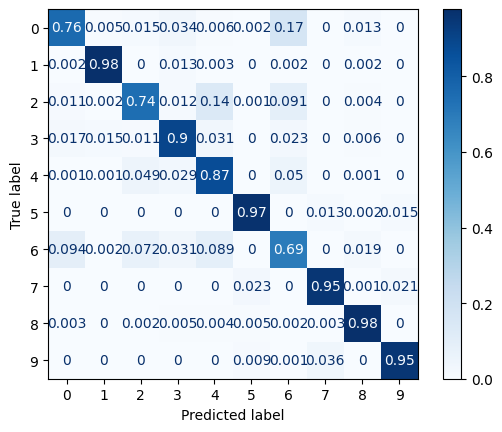

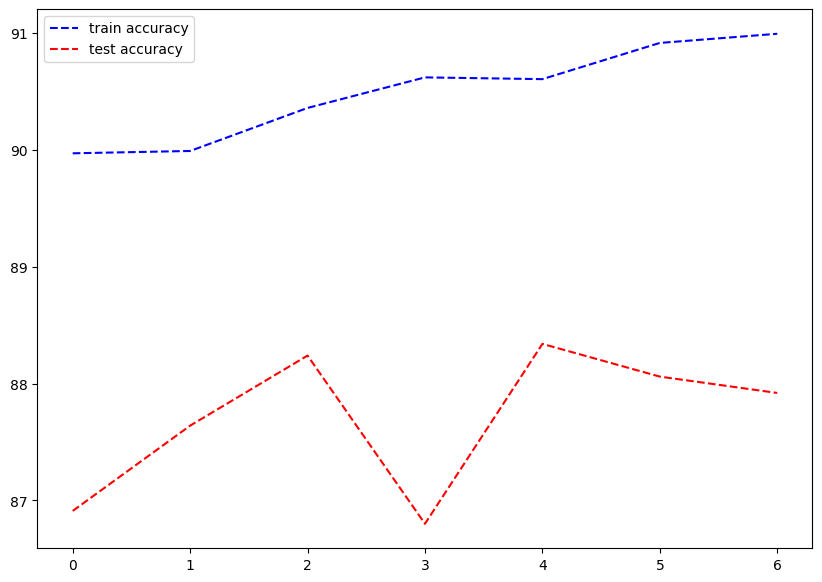

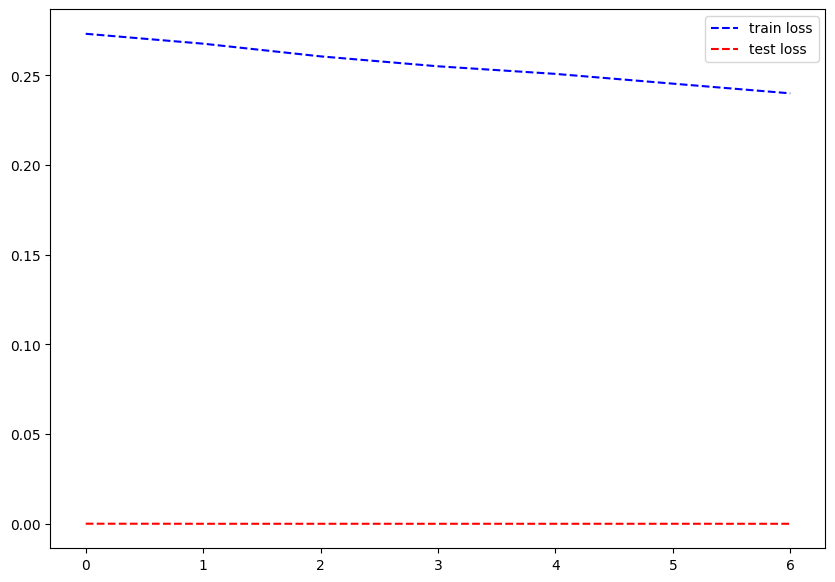

{'precision': 0.8803866073372767, 'recall': 0.8792, 'f1_score': 0.8788490604860837, 'accuracy': 87.92, 'min_loss': 9.417489010843383e-10}


In [35]:
scores = run_epochs(model_type=model)
print(scores)